In [1]:
import polars as pl
from memory_profiler import memory_usage
import time
from functools import partial

In [2]:
def determine_scalability(func, num_repetitions):
    times = []
    memories = []
    for i in range(num_repetitions):
        s = time.time()
        mem_usage = memory_usage(func)
        e = time.time()
        time_taken = e - s
        max_memory = max(mem_usage)
        times.append(time_taken)
        memories.append(max_memory)
    return times, memories


In [42]:
def rolling_from_expression(lazy_df, num_points):
    original_cols = lazy_df.columns
    expressions = [
        (
            pl.sum("value")
            .rolling("index", period="1i", offset=f"{lag}i")
            .sum()
            .alias(f"{lag}")
        )  for lag in range(num_points)
    ]
    output = (
        lazy_df
        .with_columns(expressions)
        .first()
    )
    output = list(output.collect().select(pl.exclude(original_cols)).row(0))
    return output

def rolling_from_for_loop(lazy_df, num_points):
    totals = []
    for lag in range(num_points):
        total = lazy_df.rolling("index", period=f"1i", offset=f"{lag}i").agg(
            pl.sum("value")
        ).select(pl.sum("value")).collect().item()
        totals.append(total)
    return totals

In [43]:
def create_df(num_rows):
    value_range =pl.int_range(0, num_rows)
    lazy_df = pl.LazyFrame().with_columns(index=value_range, value=value_range)
    return lazy_df

In [44]:
lazy_df = create_df(100)
lag = 98
'''print(lazy_df.rolling("index", period=f"1i", offset=f"{lag}i").agg(
    pl.sum("value")
).collect())


print(lazy_df.with_columns(pl.sum("value").rolling("index", period="1i", offset=f"{lag}i")).collect())
'''
expr = rolling_from_expression(lazy_df, lag)
loop = rolling_from_for_loop(lazy_df, lag)

In [52]:
num_points = [
    1000,
    2000,
    3000,
    4000,
    5000,
    6000,
    7000,
    8000,
    9000,
    10000,
    #50000, 100000, 500000, 1000000
]

num_iterations = 3

def collect_times_and_memory(function, num_points, num_iterations):
    data_structure = {}
    for num_rows in num_points:
        lazy_df = create_df(num_rows)
        for num_cols in num_points:
            if num_cols > num_rows:
                break
            func = partial(function, lazy_df=lazy_df, num_points=num_cols)
            times, memories = determine_scalability(func, num_iterations)
            total_time = sum(times)
            avg_time = total_time / num_iterations
            max_memory = max(memories)
            avg_memory = sum(memories) / num_iterations
            data_structure[(num_rows, num_cols)] = {
                "memory": avg_memory,
                "time": avg_time
            }
            print(f"Completed {num_rows} vs. {num_cols} in {total_time:.3g} seconds...")
    return data_structure




In [53]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def generate_matrices_and_plot(data_structure):
    time_matrix = np.zeros((len(num_points), len(num_points)))
    memory_matrix = np.zeros((len(num_points), len(num_points)))
    val_to_index = {val: i for i, val in enumerate(num_points)}
    for key in data_structure:
        i, j = val_to_index[key[0]], val_to_index[key[1]]
        time_matrix[i, j] = data_structure[key]["time"]
        memory_matrix[i, j] = data_structure[key]["memory"]
    labels = [str(val) for val in num_points]
    plt.figure()
    sns.heatmap(time_matrix, annot=True, xticklabels=labels, yticklabels=labels)
    plt.figure()
    sns.heatmap(memory_matrix/1024, annot=True, xticklabels=labels, yticklabels=labels)

In [48]:
rolling_from_expression_data = collect_times_and_memory(rolling_from_expression, num_points, num_iterations)
generate_matrices_and_plot(rolling_from_expression_data)

Completed 1000 vs. 1000 in 4.37 seconds...
Completed 2000 vs. 1000 in 2.54 seconds...
Completed 2000 vs. 2000 in 5.28 seconds...
Completed 3000 vs. 1000 in 3.58 seconds...


KeyboardInterrupt: 

Completed 1000 vs. 1000 in 3.95 seconds...
Completed 2000 vs. 1000 in 3.22 seconds...
Completed 2000 vs. 2000 in 4.46 seconds...


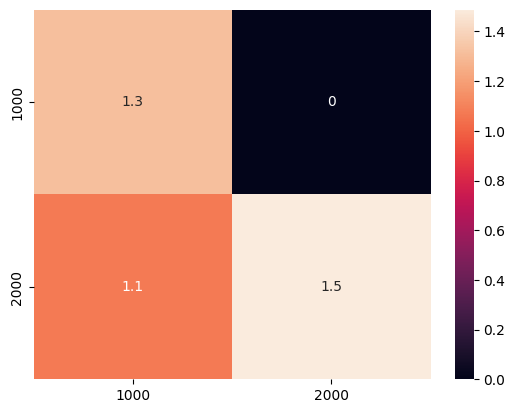

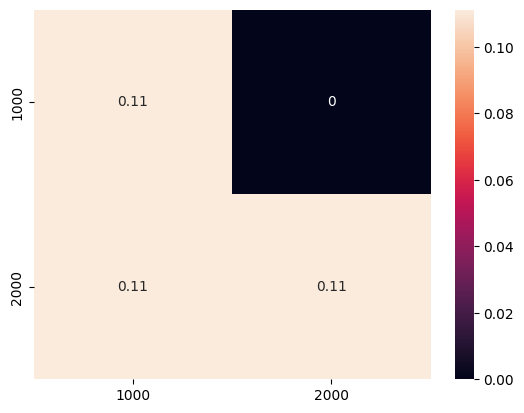

In [51]:
rolling_from_for_loop_data = collect_times_and_memory(rolling_from_for_loop, num_points, num_iterations)
generate_matrices_and_plot(rolling_from_for_loop_data)

In [26]:
lazy_df = create_df(100)
rolling_obj = lazy_df.rolling("index", offset="2i", period="1i", closed="both").agg(pl.col("value").sum().alias("test"))
rolling_obj.collect()

index,test
i64,i64
0,5
1,7
2,9
3,11
4,13
5,15
6,17
7,19
8,21


In [41]:
df = pl.DataFrame({
    "x": [1,2,3,4,5,6,7,8,9,10],
    "value": [1,2,3,4,5,6,7,8,9,10]
})

lag = 2
delta = 1

offset = lag - delta
period = 2*delta

df = df.sort("x")
rolling_obj = df.rolling("x", offset=f"{offset}i", period=f"{period}i", closed="both").agg(test=((pl.col("value") - pl.col("x"))), test2=pl.agg_groups())
rolling_obj

AttributeError: module 'polars' has no attribute 'agg_groups'